In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import re
from math import *
import csv
import xlrd
import copy
import json
import mapclassify

In [2]:
# load the districution data
covid = open('./data/covid_districution.json', 'r')
covid_districution = json.loads(covid.read())
covid.close()
bed = open('./data/bed_districution.json', 'r')
bed_districution = json.loads(bed.read())
bed.close()
pop = open('./data/pop_districution.json', 'r')
pop_districution = json.loads(pop.read())
pop.close()


In [3]:
# discrepancy
import numpy as np

def find_sign_change_array(a):
    asign = np.sign(a)
    sz = asign == 0
    if sz.any():
        asign[sz] = np.roll(asign, 1)[sz]
        sz = asign == 0
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    return signchange

def get_regions(a):
    sgn = find_sign_change_array(a)
    regs= []
    i = 0
    for j,s in enumerate(sgn):
        if s==1:
            regs += [(i,j,np.sign(a[i]))]
            i = j
    if i<j:
        regs += [(i,j,np.sign(a[i]))]
    return regs

def compute_discrepancy(source0, target0, weights=None):
    weights = np.ones(len(source0)) if weights is None else weights
    source = weights * source0
    target = weights * target0
    dif = source - target
    reg = get_regions(dif)
    top = np.array([max([i,j]) for i,j in zip(source,target)])
    tot_disc = dif.sum()/float(target.sum())
    disc=[]
    for (i,j,s) in reg:
        d = dif[i:j].sum() / float(top[i:j].sum())
        disc += [(i,j,d)]
    return tot_disc, disc

# effort
from scipy.stats import wasserstein_distance

def compute_effort_emd(source, target, weights=None):
    return wasserstein_distance(source, target, u_weights=weights, v_weights=weights)

In [4]:
# calculate discrepancy and effort
discrepancy_bed_covid, discrepancy_pop_covid, discrepancy_bed_pop = {}, {}, {}
effort_bed_covid, effort_pop_covid, effort_bed_pop = {}, {}, {}
for s in covid_districution.keys():
    discr_bed_covid = compute_discrepancy(bed_districution[s], covid_districution[s])
    discr_bed_pop = compute_discrepancy(bed_districution[s], pop_districution[s])
    discr_pop_covid = compute_discrepancy(pop_districution[s], covid_districution[s])
    
    discrepancy_bed_covid[s] = discr_bed_covid
    discrepancy_bed_pop[s] = discr_bed_pop
    discrepancy_pop_covid[s] = discr_pop_covid
    
    eff_bed_covid = compute_effort_emd(bed_districution[s], covid_districution[s])
    eff_bed_pop = compute_effort_emd(bed_districution[s], pop_districution[s])
    eff_pop_covid = compute_effort_emd(pop_districution[s], covid_districution[s])
    
    effort_bed_covid[s] = eff_bed_covid
    effort_bed_pop[s] = eff_bed_pop
    effort_pop_covid[s] = eff_pop_covid

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sign
  """


# bed & covid

In [5]:
# descrepancy_bed_covid
df_discrepancy_bed_covid = pd.DataFrame.from_dict(discrepancy_bed_covid, orient="index", columns=["bed_covid_discrepancy","bed_covid_details"])
df_discrepancy_bed_covid = df_discrepancy_bed_covid.reset_index().rename(columns={"index":"STATE"})
df_discrepancy_bed_covid["bed_covid_discrepancy"] = df_discrepancy_bed_covid["bed_covid_discrepancy"].fillna(0)
# df_discrepancy_bed_covid

# effort_bed_covid
df_effort_bed_covid = pd.DataFrame.from_dict(effort_bed_covid, orient="index", columns=["bed_covid_effort"])
df_effort_bed_covid = df_effort_bed_covid.reset_index().rename(columns={"index":"STATE"})
df_effort_bed_covid["bed_covid_effort"] = df_effort_bed_covid["bed_covid_effort"].fillna(0)
# df_effort_bed_covid

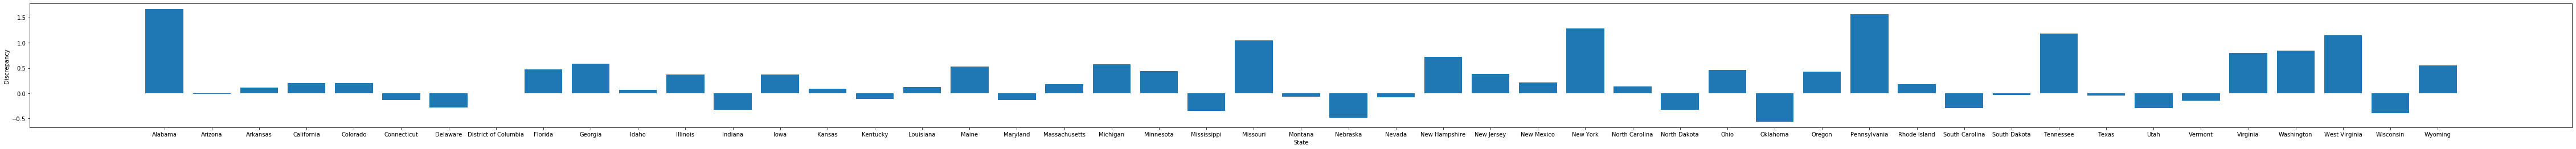

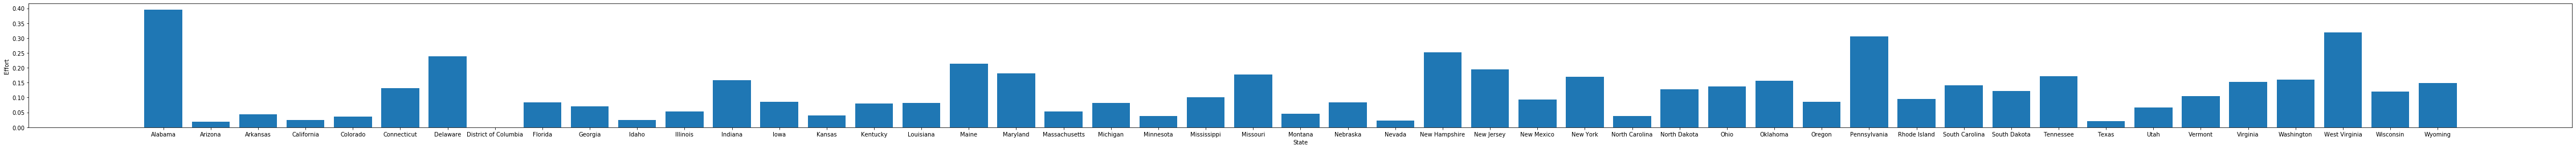

In [6]:
plt.rcParams['figure.figsize'] = (80, 4.0)
plt.figure()
plt.bar(df_discrepancy_bed_covid["STATE"],df_discrepancy_bed_covid["bed_covid_discrepancy"])
plt.xlabel("State")
plt.ylabel("Discrepancy")
plt.show()

plt.figure()
plt.bar(df_effort_bed_covid["STATE"],df_effort_bed_covid["bed_covid_effort"])
plt.xlabel("State")
plt.ylabel("Effort")
plt.show()

In [7]:
# count for discrepancy (<0, =0, >0)
df_discrepancy_bed_covid['level'] = df_discrepancy_bed_covid.apply(lambda x: np.sign(x.bed_covid_discrepancy), axis = 1)
# df_discrepancy_bed_covid
count_dis_bed_covid = df_discrepancy_bed_covid.groupby("level")["STATE"].size()
count_dis_bed_covid

level
-1.0    18
 0.0     1
 1.0    30
Name: STATE, dtype: int64

# population & covid

In [8]:
# discrepancy_pop_covid
df_discrepancy_pop_covid = pd.DataFrame.from_dict(discrepancy_pop_covid, orient="index", columns=["pop_covid_discrepancy","pop_covid_details"])
df_discrepancy_pop_covid = df_discrepancy_pop_covid.reset_index().rename(columns={"index":"STATE"})
df_discrepancy_pop_covid["pop_covid_discrepancy"] = df_discrepancy_pop_covid["pop_covid_discrepancy"].fillna(0)
# df_discrepancy_pop_covid

# effort_pop_covid
df_effort_pop_covid = pd.DataFrame.from_dict(effort_pop_covid, orient="index", columns=["pop_covid_effort"])
df_effort_pop_covid = df_effort_pop_covid.reset_index().rename(columns={"index":"STATE"})
df_effort_pop_covid["pop_covid_effort"] = df_effort_pop_covid["pop_covid_effort"].fillna(0)
# df_effort_pop_covid

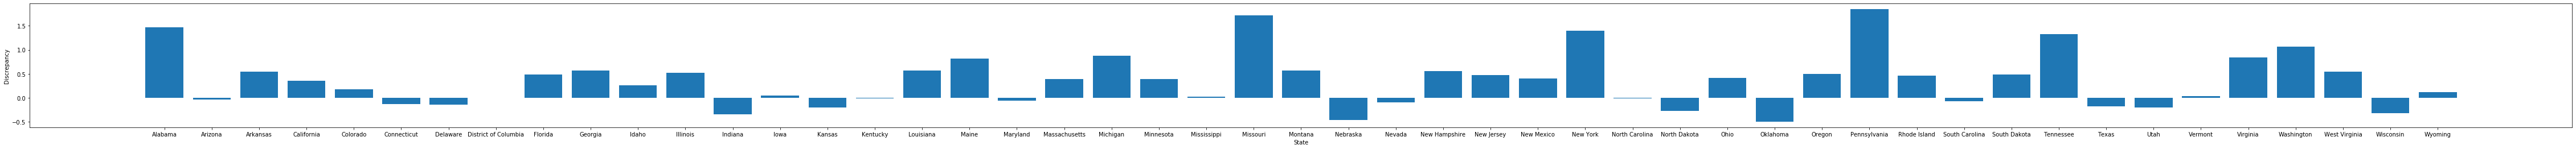

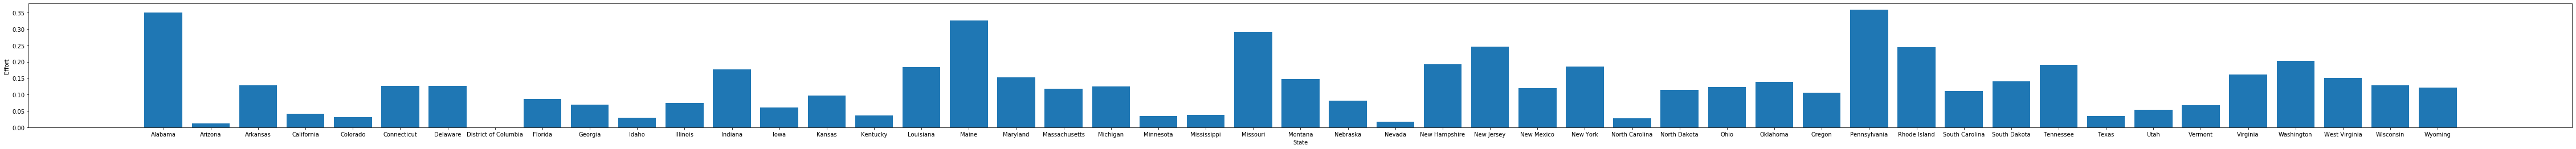

In [9]:
plt.rcParams['figure.figsize'] = (80, 4.0)
plt.figure()
plt.bar(df_discrepancy_pop_covid["STATE"],df_discrepancy_pop_covid["pop_covid_discrepancy"])
plt.xlabel("State")
plt.ylabel("Discrepancy")
plt.show()

plt.figure()
plt.bar(df_effort_pop_covid["STATE"],df_effort_pop_covid["pop_covid_effort"])
plt.xlabel("State")
plt.ylabel("Effort")
plt.show()

In [10]:
# count for discrepancy (<0, =0, >0)
df_discrepancy_pop_covid['level'] = df_discrepancy_pop_covid.apply(lambda x: np.sign(x.pop_covid_discrepancy), axis = 1)
# df_discrepancy_bed_covid
count_dis_pop_covid = df_discrepancy_pop_covid.groupby("level")["STATE"].size()
count_dis_pop_covid

level
-1.0    16
 0.0     1
 1.0    32
Name: STATE, dtype: int64

# bed & population

In [11]:
# discrepancy_bed_pop
df_discrepancy_bed_pop = pd.DataFrame.from_dict(discrepancy_bed_pop, orient="index", columns=["bed_pop_discrepancy","bed_pop_details"])
df_discrepancy_bed_pop = df_discrepancy_bed_pop.reset_index().rename(columns={"index":"STATE"})
df_discrepancy_bed_pop["bed_pop_discrepancy"] = df_discrepancy_bed_pop["bed_pop_discrepancy"].fillna(0)
# df_discrepancy_bed_pop

# effort_bed_pop
df_effort_bed_pop = pd.DataFrame.from_dict(effort_bed_pop, orient="index", columns=["bed_pop_effort"])
df_effort_bed_pop = df_effort_bed_pop.reset_index().rename(columns={"index":"STATE"})
df_effort_bed_pop["bed_pop_effort"] = df_effort_bed_pop["bed_pop_effort"].fillna(0)
# df_effort_bed_pop

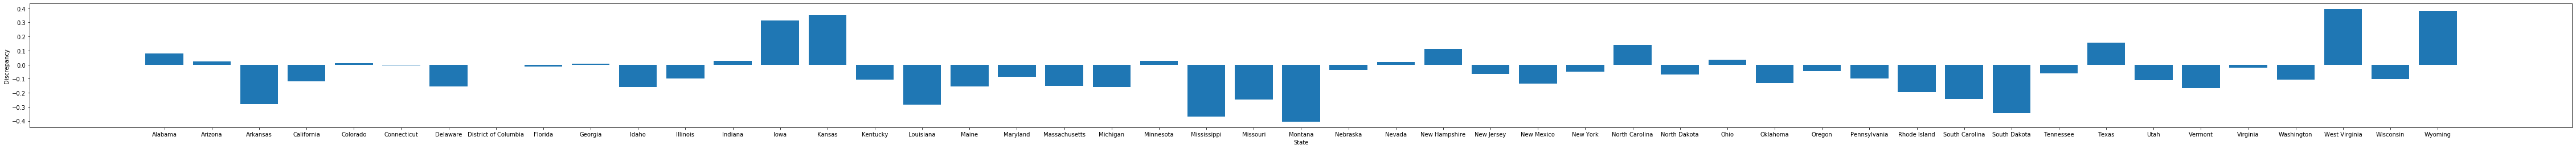

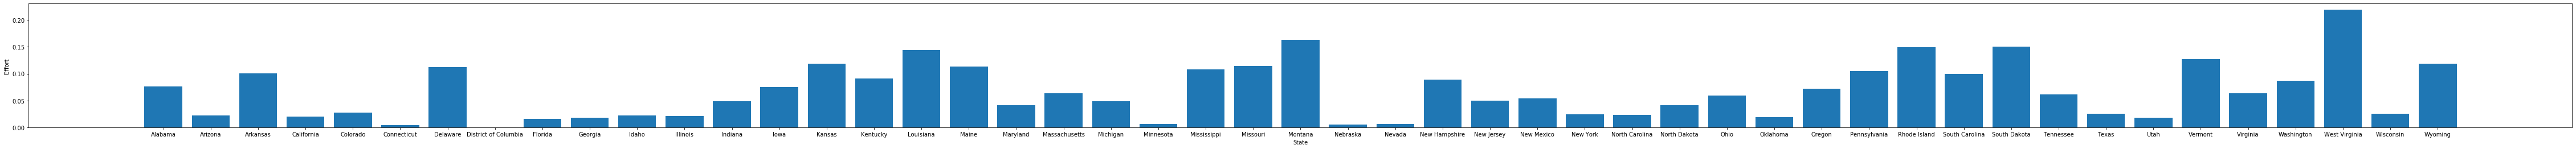

In [12]:
plt.rcParams['figure.figsize'] = (80, 4.0)
plt.figure()
plt.bar(df_discrepancy_bed_pop["STATE"],df_discrepancy_bed_pop["bed_pop_discrepancy"])
plt.xlabel("State")
plt.ylabel("Discrepancy")
plt.show()

plt.figure()
plt.bar(df_effort_bed_pop["STATE"],df_effort_bed_pop["bed_pop_effort"])
plt.xlabel("State")
plt.ylabel("Effort")
plt.show()

In [13]:
# count for discrepancy (<0, =0, >0)
df_discrepancy_bed_pop['level'] = df_discrepancy_bed_pop.apply(lambda x: np.sign(x.bed_pop_discrepancy), axis = 1)
# df_discrepancy_bed_covid
count_dis_bed_pop = df_discrepancy_bed_pop.groupby("level")["STATE"].size()
count_dis_bed_pop

level
-1.0    33
 0.0     1
 1.0    15
Name: STATE, dtype: int64

# merge all results

In [14]:
df_final = pd.DataFrame(columns=["STATE"])
dfs=[df_discrepancy_bed_covid, df_discrepancy_pop_covid, df_discrepancy_bed_pop, df_effort_bed_covid, df_effort_pop_covid, df_effort_bed_pop]
for df in dfs:
    df_final = df_final.merge(df, on=['STATE'], how='outer')
df_final = df_final.drop(["bed_covid_details","pop_covid_details","bed_pop_details","level_x","level_y","level"],axis=1)
# drop DC
df_final = df_final.drop([7])
df_final = df_final.reset_index(drop=True)
df_final

,STATE,bed_covid_discrepancy,pop_covid_discrepancy,bed_pop_discrepancy,bed_covid_effort,pop_covid_effort,bed_pop_effort
0,Alabama,1.661439,1.467322,0.078675,0.395867,0.349615,0.076486
1,Arizona,-0.010258,-0.033136,0.023662,0.018081,0.011071,0.021548
2,Arkansas,0.116441,0.547162,-0.278395,0.043346,0.128174,0.100898
3,California,0.199406,0.358977,-0.117420,0.024146,0.040969,0.020308
4,Colorado,0.197548,0.183147,0.012172,0.036853,0.030663,0.026923
5,Connecticut,-0.139185,-0.134572,-0.005330,0.131508,0.127150,0.004358
6,Delaware,-0.279507,-0.147932,-0.154418,0.238803,0.126389,0.112414
7,Florida,0.466935,0.489619,-0.015228,0.083406,0.085615,0.015173
8,Georgia,0.585109,0.574009,0.007052,0.069933,0.068606,0.017510
9,Idaho,0.064884,0.263739,-0.157355,0.024872,0.029578,0.022038


In [15]:
# max->min
import copy
ranks = copy.copy(df_final)
ranks[list(df_final.columns[1:])] = df_final[list(df_final.columns[1:])].rank(method="min", ascending=False)
ranks

,STATE,bed_covid_discrepancy,pop_covid_discrepancy,bed_pop_discrepancy,bed_covid_effort,pop_covid_effort,bed_pop_effort
0,Alabama,1.0,3.0,8.0,1.0,2.0,19.0
1,Arizona,31.0,35.0,12.0,48.0,48.0,38.0
2,Arkansas,28.0,14.0,44.0,39.0,20.0,14.0
3,California,22.0,26.0,32.0,45.0,39.0,40.0
4,Colorado,23.0,28.0,14.0,43.0,44.0,32.0
5,Connecticut,38.0,39.0,16.0,19.0,21.0,48.0
6,Delaware,40.0,40.0,36.0,5.0,22.0,11.0
7,Florida,14.0,18.0,17.0,30.0,32.0,44.0
8,Georgia,10.0,10.0,15.0,34.0,35.0,43.0
9,Idaho,30.0,27.0,38.0,44.0,45.0,37.0


In [16]:
outputpath = "./data/discr_eff/"
if not os.path.exists(outputpath):
    os.makedirs(outputpath)
df_final.to_csv(os.path.join(outputpath, "discr_eff_val.csv"))
ranks.to_csv(os.path.join(outputpath, "discr_eff_rank.csv"))

# evaluate

In [17]:

import os
evaluatepath = "./data/discr_eff/"
avaliable_bed = pd.read_csv(os.path.join(evaluatepath, "Summary_stats_all_locs.csv"),header=0)
avaliable_bed = avaliable_bed[["location_name", "available_all_nbr"]]
# avaliable_bed

healthrank_path = "./data/discr_eff/"
state_rank = pd.read_excel(os.path.join(healthrank_path, "stateRank.xlsx"),header=None)

# drop Alaska and Hawaii
state_rank = state_rank.drop([0,10])
state_rank = state_rank.reset_index(drop=True)
state_rank["OverallRank"] = state_rank[5].rank(method="min", ascending=False)
# state_rank

new_rank = pd.merge(ranks, avaliable_bed, left_on =["STATE"], right_on=["location_name"], how="left")
new_rank["bedRank"] = new_rank["available_all_nbr"].rank(method="min", ascending=False)


dis1 = list(ranks.bed_covid_discrepancy)
# r_dis_pc = list(ranks.pop_covid_discrepancy)
# r_dis_bp = list(ranks.bed_pop_discrepancy)
eff1 = list(ranks.bed_covid_effort)
# r_eff_pc = list(ranks.pop_covid_effort)
# r_eff_bp = list(ranks.bed_pop_effort)
# dis_ranks = [r_dis_bc, r_dis_pc, r_dis_bp]
# eff_ranks = [r_eff_bc, r_eff_pc, r_eff_bp]
healthrank = list(state_rank.OverallRank)
bedrank = list(new_rank.bedRank)

from scipy import stats
print("Bed Rank:")
print("discrepancy:")
print(stats.spearmanr(dis1, bedrank),stats.kendalltau(dis1, bedrank))
print("\n effort:")
print(stats.spearmanr(eff1, bedrank),stats.kendalltau(eff1, bedrank))

print("\nHealth Rank:")
print("discrepancy:")
print(stats.spearmanr(dis1, healthrank),stats.kendalltau(dis1, healthrank))
print("\n effort:")
print(stats.spearmanr(eff1, healthrank),stats.kendalltau(eff1, healthrank))

Bed Rank:
discrepancy:
SpearmanrResult(correlation=0.30525401650021705, pvalue=0.03487913654065799) KendalltauResult(correlation=0.20035460992907803, pvalue=0.04456926421584259)

 effort:
SpearmanrResult(correlation=-0.13341293964394269, pvalue=0.36599662767031493) KendalltauResult(correlation=-0.09929078014184398, pvalue=0.31951233651960764)

Health Rank:
discrepancy:
SpearmanrResult(correlation=0.05134607034303083, pvalue=0.7289011140152404) KendalltauResult(correlation=0.04609929078014185, pvalue=0.6439536077376282)

 effort:
SpearmanrResult(correlation=-0.017042987407729047, pvalue=0.9084664677267075) KendalltauResult(correlation=-0.019503546099290784, pvalue=0.8449726626091453)
